In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import norm
import pandas as pd
from math import *
import scipy.stats
from pandas import *
from scipy.integrate import quad
import seaborn as sns
import scipy as s
import warnings
from mpl_toolkits import mplot3d
from scipy import linalg
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")

from matplotlib.ticker import ScalarFormatter

In [ ]:
# The below is to load the Fredholm NN classes - Adjust according to your folder architecture/path where the fredholm_nn_models.py has been saved

from google.colab import drive
drive.mount('/content/drive')

FOLDER = "/content/drive/MyDrive/Fredholm_Neural_Networks/Github/Python"

import sys, os, importlib
if FOLDER not in sys.path:
    sys.path.insert(0, FOLDER)   # <-- make folder importable

print("CWD:", os.getcwd())
print("Folder exists?", os.path.isdir(FOLDER))
print("Files:", os.listdir(FOLDER)[:10])


from fredholm_nn_models import FredholmNeuralNetwork, FredholmNeuralNetwork_KM


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CWD: /content
Folder exists? True
Files: ['Fredholm_Integral_Examples_Modular.ipynb', 'Fredholm_Integral_Non_Linear_Examples_Modular.ipynb', 'Fredholm_Integral_Examples_ModularOld.ipynb', 'Fredholm_NN_Poisson_PDE.ipynb', 'Fredholm_NN_Helmholtz_PDE.ipynb', 'Fredholm_NN_Semi-linear_PDE.ipynb', 'fredholm_nn_models.py', '__pycache__']


## Fredholm Neural Networks for Fredholm Integral Equations

### Example FIE 1.

$$f(x) = sin(25x)+sin(7x) + \int_0^1 \Big(cos\big(25(x-y)\big)+cos\big(7(x-y)\big)\Big)f(y)dy $$

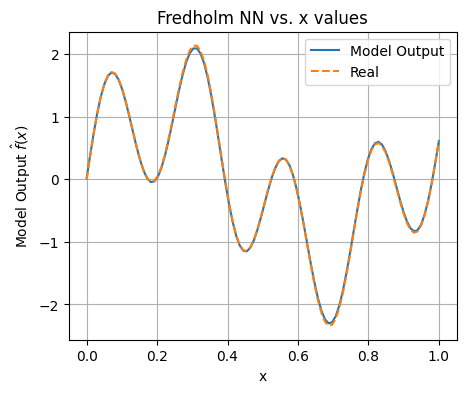

In [ ]:
lamb = 0.3
def kernel(in_value, out_value):
    return lamb*(np.cos(25*(out_value - in_value)) + np.cos(7*(out_value - in_value)))

def additive(out_value):
    return np.sin(25*out_value) + np.sin(7*out_value)

# Create grid_dictionary and grid_step dynamically
K = 50
z_0 = 0.0
z_n = 1.0
zsteps = 500

dz = (z_n - z_0) / zsteps
z = np.arange(z_0, z_n + dz, dz)

grid_dictionary = {f'layer_{i}': z for i in range(K + 1)}

# Define predict array
x_list = torch.tensor(np.linspace(0.0, 1.0, 100), dtype=torch.float32)  # Values for the final output

# Instantiate the model
input_size = len(z)
output_size = len(x_list)
model = FredholmNeuralNetwork(grid_dictionary, kernel, additive, dz, K, input_size, output_size)

# Forward pass
output = model(x_list)
# Plot the results
plt.figure(figsize=(5, 4))
plt.plot(x_list.numpy(), output.detach().numpy(), label="Model Output")
plt.plot(x_list.numpy(), (2/(2-lamb))*(np.sin(25*x_list) + np.sin(7*x_list)), label="Real", linestyle="--")
plt.xlabel("x")
plt.ylabel("Model Output $\hat{f}(x)$")
plt.title("Fredholm NN vs. x values")
plt.legend()
plt.grid(True)
plt.show()


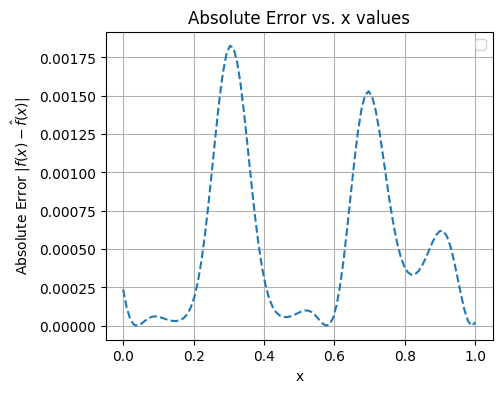

Prediction MSE: 5.325094889485626e-07


In [ ]:
# Calculate and plot error errors - test various values of layers and nodes to see the corresponding errors

error = np.abs(output.detach().numpy() - (2/(2-lamb))*(np.sin(25*x_list) + np.sin(7*x_list)).detach().numpy())**2
mse = np.mean(error**2)

plt.figure(figsize=(5, 4))
plt.plot(x_list.numpy(), error, linestyle="--")
plt.xlabel("x")
plt.ylabel("Absolute Error $|f(x) - \hat{f}(x)|$")
plt.title("Absolute Error vs. x values")
plt.legend()
plt.grid(True)
plt.show()

print(f"Prediction MSE: {mse}")


### Example FIE 2.
$$ f(x) = sin(x) + \int_0^{\pi/2} sin(x)cos(y)f(y) dy. $$

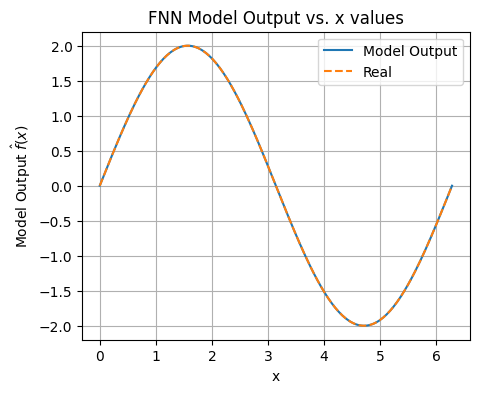

In [ ]:
def kernel(in_value, out_value):

    return np.sin(out_value)*np.cos(in_value)

def additive(out_value):
    return np.sin(out_value)


# Create grid_dictionary and grid_step dynamically
K = 15
y_0 = 0.0
y_n = np.pi/2
ysteps = 500

dy = (y_n - y_0) / ysteps
y = np.arange(y_0, y_n + dy, dy)

grid_dictionary = {f'layer_{i}': y for i in range(K + 1)}

# Define predict array
x_list = torch.tensor(np.linspace(0,2*np.pi, 200), dtype=torch.float32)  # Values for the final output

# Instantiate the model
input_size = len(y)
output_size = len(x_list)
model = FredholmNeuralNetwork(grid_dictionary, kernel, additive, dy, K, input_size, output_size)

# Forward pass
output = model(x_list)
# Plot the results
plt.figure(figsize=(5, 4))
plt.plot(x_list.numpy(), output.detach().numpy(), label="Model Output")
plt.plot(x_list.numpy(), 2*np.sin(x_list.numpy()), label="Real", linestyle="--")
plt.xlabel("x")
plt.ylabel("Model Output $\hat{f}(x)$")
plt.title("FNN Model Output vs. x values")
plt.legend()
plt.grid(True)
plt.show()

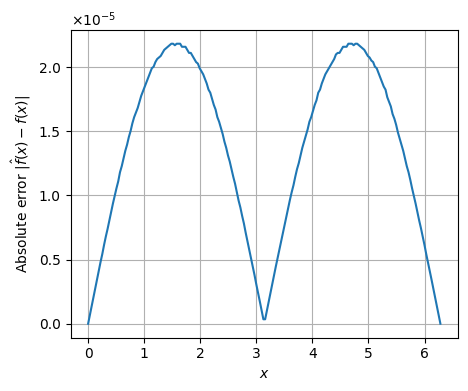

In [ ]:
# ScalarFormatter to force one decimal place.
class OneDecimalScalarFormatter(ScalarFormatter):
    def _set_format(self):
        # This forces the formatter to always use one decimal place
        self.format = '%.1f'

real_f = [2.0*np.sin(i) for i in x_list]
error = np.abs((output-np.array(real_f)))

plt.figure(figsize = (5,4))
plt.plot(x_list, error)
ax = plt.gca()
formatter = OneDecimalScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)
plt.xlabel(r'$x$')
plt.ylabel(r'Absolute error $|\hat{f}(x) - f(x)|$')
plt.grid(True)

plt.show()

### Example FIE 3.
$$ f(x) = e^x + \int_0^1 \frac{1}{e}f(z)dz  $$

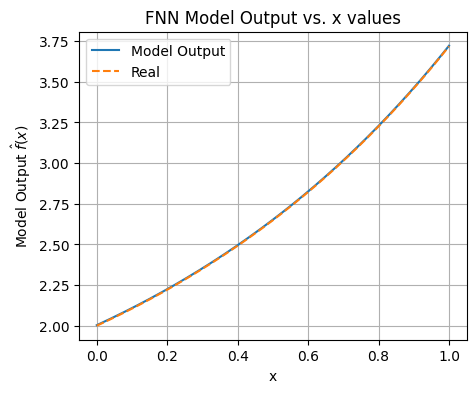

In [ ]:
import numpy as np
import torch
import math

def kernel(in_value, out_value):

    iv = np.asarray(in_value)
    ov = np.asarray(out_value)
    target_shape = np.broadcast(iv, ov).shape  # (N,M) or () for scalars
    return np.full(target_shape, 1.0 / math.e, dtype=float)

def additive(out_value):

    if isinstance(out_value, torch.Tensor):
        return torch.exp(out_value)
    return np.exp(out_value)


# Create grid_dictionary and grid_step dynamically
K = 10
z_0 = 0.0
z_n = 1.0
zsteps = 500

dz = (z_n - z_0) / zsteps
z = np.arange(z_0, z_n + dz, dz)


grid_dictionary = {f'layer_{i}': z for i in range(K + 1)}

# Define predict array
x_list = torch.tensor(np.linspace(0, 1, 200), dtype=torch.float32)  # Values for the final output

# Instantiate the model
input_size = len(z)
output_size = len(x_list)
model = FredholmNeuralNetwork(grid_dictionary, kernel, additive, dz, K, input_size, output_size)

# Forward pass
output = model(x_list)
# Plot the results
plt.figure(figsize=(5, 4))
plt.plot(x_list.numpy(), output.detach().numpy(), label="Model Output")
plt.plot(x_list.numpy(), np.exp(x_list)+1, label="Real", linestyle="--")
plt.xlabel("x")
plt.ylabel("Model Output $\hat{f}(x)$")
plt.title("FNN Model Output vs. x values")
plt.legend()
plt.grid(True)
plt.show()


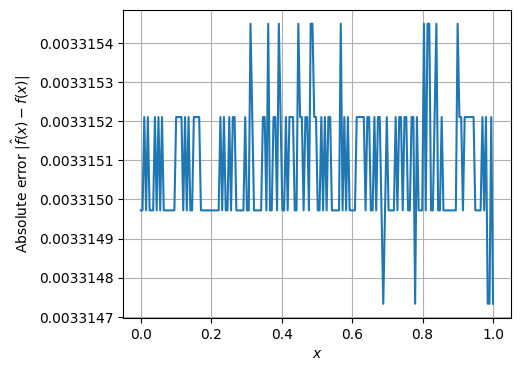

In [ ]:
real_f = [np.exp(i)+1 for i in x_list]
error = np.abs((output-np.array(real_f)))

plt.figure(figsize = (5,4))
plt.plot(x_list, error)
ax = plt.gca()
plt.xlabel(r'$x$')
plt.ylabel(r'Absolute error $|\hat{f}(x) - f(x)|$')
plt.grid(True)
plt.show()

# Fredholm Neural Networks for BVP ODEs

Fredholm NNs can be used to solve ODEs using the following result:

   Consider an ODE of the form:
    \begin{eqnarray}
    y''(x) + g(x)y(x) = h(x), \,\,\,\, 0<x<1,
    \end{eqnarray}   
    with $y(0) = \alpha, y(1) = \beta$.
Then we can solve the ODE by obtaining the following Fredholm IE:
\begin{eqnarray}
    u(x) = f(x) + \int_{0}^{1} K(x,t) u(t)dt,
\end{eqnarray}
where:
\begin{eqnarray}
    u(x) = y''(x), \\
    f(x) = h(x) - \alpha g(x) - (\beta - \alpha) x g(x).
\end{eqnarray}
The kernel is given by:
\begin{eqnarray}
K(x,t) =
    \begin{cases}
        t(1-x)g(x), \,\,\, 0 \leq t \leq x \\
        x(1-t)g(x), \,\,\, x\leq t \leq 1.
    \end{cases}
\end{eqnarray}
Finally, by definition of $u(x)$, we can obtain the solution to the ODE by:
\begin{eqnarray}
    y(x) = \frac{h(x) - u(x)}{g(x)}.
\end{eqnarray}

## Example BVP ODE 1.

We consider the ODE   \begin{equation}
        y''(x) + \frac{3p}{(p+x^2)^2}y(x) = 0, \,\,\,  x \in [0.0, 1.0]
    \end{equation}
  and with boundary conditions:
    \begin{eqnarray}
        y(0) = 0 \,\,\,\,\,\,\ y(1) = 1.0/\sqrt{p + 1.0}.
    \end{eqnarray}

The analytical solution is known to be:
\begin{eqnarray}
    y(x) = \frac{x}{\sqrt{p + x^2}}.
\end{eqnarray}
We can obtain a Fredholm Integral Equation with the kernel and additive term shown below.

In [ ]:
# ODE parameters and functions
p = 3.2
lower = 0.0 / np.sqrt(p + 0.0)
upper = 1.0 / np.sqrt(p + 1.0)

def g_func(x):

    g = 3.0*p/(p+x**2)**2

    return g

def h_func(x):

    h = 0.0

    return h


# General form of kernels for ODE to IE transformation
def kernel(in_value, out_value):

    ode_kernel = in_value*(1-out_value)*(in_value <= out_value) + out_value*(1-in_value)*(out_value <= in_value)

    return g_func(out_value)*ode_kernel


def additive(out_value):

    return h_func(out_value) - lower*g_func(out_value) - (upper - lower)*out_value*g_func(out_value)

In [ ]:
# Create grid_dictionary and grid_step dynamically
K = 10
t_0 = 0.0
t_n = 1.0
tsteps = 1000

dt = (t_n - t_0) / tsteps
t = np.arange(t_0, t_n + dt, dt)

grid_dictionary = {f'layer_{i}': t for i in range(K + 1)}

# Define predict array
x_list = torch.tensor(np.linspace(0,1.0, 200), dtype=torch.float32)  # Values for the final output

# Instantiate the model
input_size = len(t)
output_size = len(x_list)
model = FredholmNeuralNetwork(grid_dictionary, kernel, additive, dt, K, input_size, output_size)

# Forward pass
output = model(x_list)

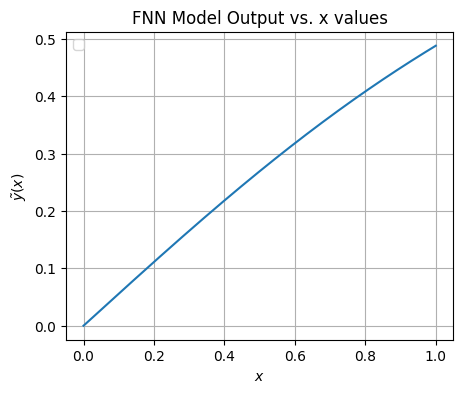

In [ ]:
# Map back to the solution of the ODE, as described above

upred_ode = (h_func(x_list) - output) / g_func(x_list)

# Plot the resulting solution
plt.figure(figsize=(5, 4))
plt.plot(x_list, upred_ode)
plt.xlabel(r'$x$')
plt.ylabel(r'$\tilde{y}(x)$')
plt.title("FNN Model Output vs. x values")
plt.legend()
plt.grid(True)
plt.show()


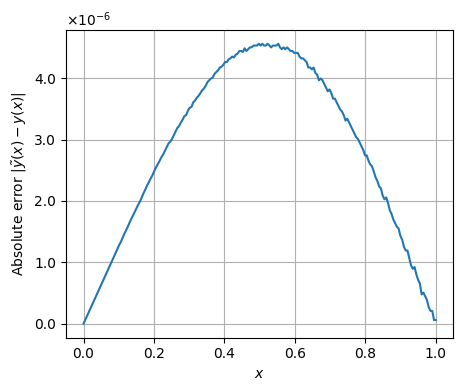

In [ ]:
from matplotlib.ticker import ScalarFormatter

# 1) Subclass ScalarFormatter to force one decimal place.
class OneDecimalScalarFormatter(ScalarFormatter):
    def _set_format(self):
        # This forces the formatter to always use one decimal place
        self.format = '%.1f'


real_f = [i/(np.sqrt(p+i**2)) for i in x_list]
error = np.abs((upred_ode-np.array(real_f)))
plt.figure(figsize = (5,4))
plt.plot(x_list, error)

ax = plt.gca()
formatter = OneDecimalScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)

plt.xlabel(r'$x$')
plt.ylabel(r'Absolute error $|\tilde{y}(x) - y(x)|$')
plt.grid(True)
plt.show()

## Example BVP ODE 2.

We consider the BVP ODE given by:
    \begin{equation}
        y''(x) + xy(x) = 0, \,\,\, x \in [0.0, 1.0]
    \end{equation}
    and with boundary conditions:
    \begin{eqnarray}
        y(0.0) = 0.0 \,\,\,\,\,\,\ y(1.0) = 2.0.
    \end{eqnarray}
With $f(x) = -2x^2$ and the kernel as defined above, it is straightforward to obtain the corresponding Fredholm IE:
\begin{eqnarray}
u(x) = -2x^2 + \int_0^1 K(x,t)u(t)dt,
\end{eqnarray}

The analytical solution of this ODE depends on the Airy functions:
\begin{eqnarray}
    y(x) = \frac{2\big(\sqrt{3}Ai(\sqrt[3]{-1}x)- Bi(\sqrt[3]{-1}x)\big)}{Ai(\sqrt[3]{-1})- Bi(\sqrt[3]{-1})}
\end{eqnarray}

In [ ]:
from scipy import special

In [ ]:
lower = 0.0
upper = 2.0

def g_func(x):

    g = x

    return g

def h_func(x):

    h = 0.0

    return h

# Exact solution functions
def ai(x):

    ai, aip, bi, bip = special.airy(x)

    return ai

def bi(x):

    ai, aip, bi, bip = special.airy(x)

    return bi

def exact_solution(x):

    s = 2*(np.sqrt(3)*ai(((-1)**(1/3))*x) - bi(((-1)**(1/3))*x))/ (np.sqrt(3)*ai((-1)**(1/3)) - bi((-1)**(1/3)))

    return s

In [ ]:
# Create grid_dictionary and grid_step dynamically
K = 15
t_0 = 0.0
t_n = 1.0
tsteps = 1000

dt = (t_n - t_0) / tsteps
t = np.arange(t_0, t_n + dt, dt)

grid_dictionary = {f'layer_{i}': t for i in range(K + 1)}

# Define predict array
x_list = torch.tensor(np.linspace(0,1.0, 200), dtype=torch.float32)  # Values for the final output

# Instantiate the model
input_size = len(t)
output_size = len(x_list)
model = FredholmNeuralNetwork(grid_dictionary, kernel, additive, dt, K, input_size, output_size)

# Forward pass
output = model(x_list)


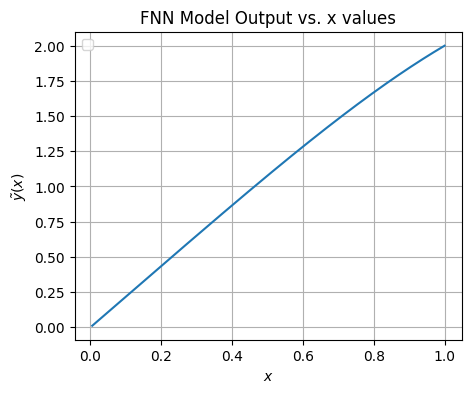

In [ ]:
# Map back to the solution of the ODE, as described above

upred_ode = (h_func(x_list) - output) / g_func(x_list)

# Plot the resulting solution
plt.figure(figsize=(5, 4))
plt.plot(x_list, upred_ode)
plt.xlabel(r'$x$')
plt.ylabel(r'$\tilde{y}(x)$')
plt.title("FNN Model Output vs. x values")
plt.legend()
plt.grid(True)
plt.show()


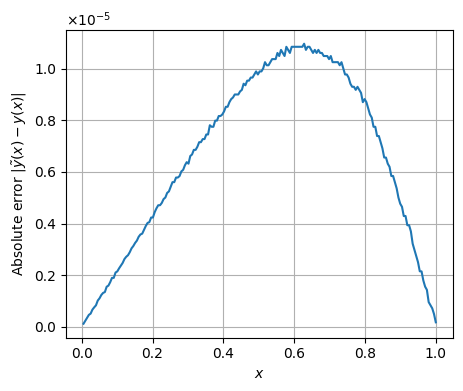

In [ ]:
# Plot absolute error in Neural Network prediction
# Create the plot
from matplotlib.ticker import ScalarFormatter

# 1) Subclass ScalarFormatter to force one decimal place.
class OneDecimalScalarFormatter(ScalarFormatter):
    def _set_format(self):
        # This forces the formatter to always use one decimal place
        self.format = '%.1f'


real_f = [exact_solution(i) for i in x_list]
error = np.abs((upred_ode-np.array(real_f)))
plt.figure(figsize = (5,4))
plt.plot(x_list, error)

ax = plt.gca()
formatter = OneDecimalScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)

plt.xlabel(r'$x$')
plt.ylabel(r'Absolute error $|\tilde{y}(x) - y(x)|$')
plt.grid(True)
plt.show()

# Fredholm Neural Networks for non-linear FIEs
